# Selecting Categorical Features

The purpose of this notebook is to determine which categorical features I want to keep.  

I take a simplistic approach and see if there are differences in charge-off rate for the different values of each of the categorical variables.

### Importing Packages

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
df_default = pd.read_csv('data_processed/02_mostly_nulls_removed.csv', low_memory=False)

In [3]:
lst_categorical = sorted(list(df_default.columns[df_default.dtypes=='object']))
lst_categorical

['addr_state',
 'application_type',
 'debt_settlement_flag',
 'disbursement_method',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'grade',
 'hardship_flag',
 'home_ownership',
 'initial_list_status',
 'issue_d',
 'last_credit_pull_d',
 'last_pymnt_d',
 'purpose',
 'pymnt_plan',
 'sub_grade',
 'term',
 'title',
 'url',
 'verification_status',
 'zip_code']

## Checking Base-Rates

In [4]:
df_default['charged_off'].mean()

0.20001681322191772

In [5]:
np.sum(df_default['charged_off'] * df_default['loan_amnt'])

1848347600.0

In [6]:
np.sum(df_default['charged_off'] * df_default['loan_amnt']) / np.sum(df_default['loan_amnt'])

0.21578509005280022

## Individual Analysis of Categorical Variables

### `addr_state` (keep)

There seems to be high variability so I will keep these.  **May need to create an other category.  Need to find rules of thumb for this.**

In [7]:
df_default['addr_state'].value_counts()

addr_state
CA    86763
TX    48760
NY    48511
FL    42375
IL    22782
NJ    21333
PA    20124
OH    19252
GA    19214
VA    16826
NC    16740
MI    15561
AZ    14410
MD    13792
MA    13530
CO    13178
WA    12949
MN    10683
IN     9540
MO     9277
TN     9071
NV     8958
CT     8778
WI     7837
AL     7233
OR     7222
SC     7092
LA     6962
KY     5663
OK     5380
KS     5012
UT     4531
AR     4429
NM     3271
HI     2962
NH     2950
MS     2931
RI     2684
WV     2244
MT     1713
DE     1678
NE     1645
DC     1507
AK     1355
WY     1329
SD     1203
VT     1156
ME      932
ND      723
ID      717
IA        2
Name: count, dtype: int64

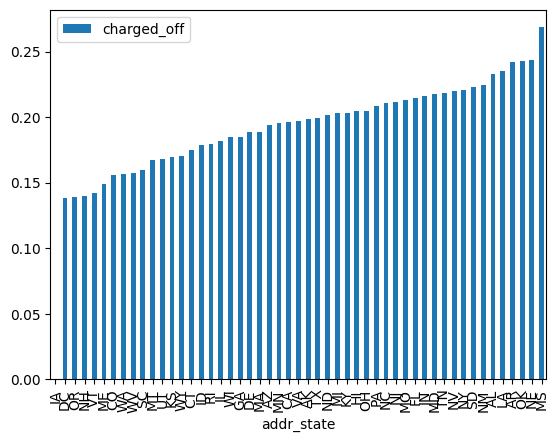

In [8]:
df_default.groupby(['addr_state'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

### `application_type` (drop)

Directionally it doesn't make sense and the joint app pool is very small, so might be dealing with a small $n$ problem.

In [9]:
df_default['application_type'].value_counts()

application_type
Individual    583383
Joint App      11387
Name: count, dtype: int64

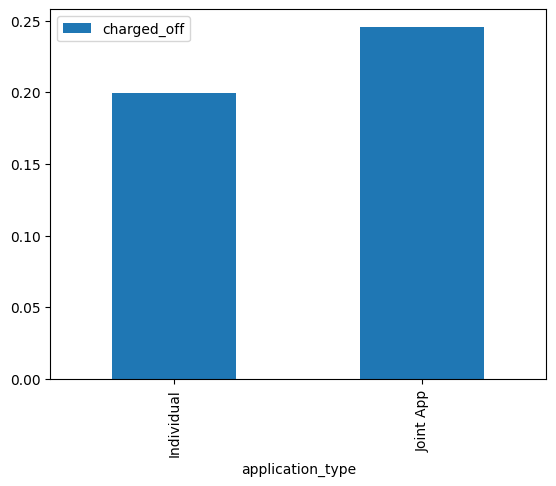

In [10]:
df_default.groupby(['application_type'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

### `debt_settlement_flag` (drop)

This seems like some kind of indicator after the fact.  Future looking, so I won't include.

In [11]:
df_default['debt_settlement_flag'].value_counts()

debt_settlement_flag
N    579972
Y     14798
Name: count, dtype: int64

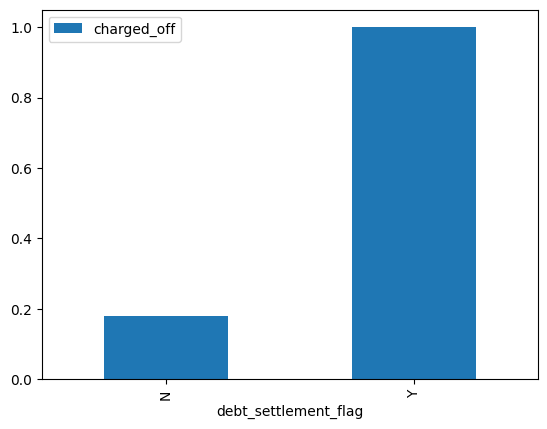

In [12]:
df_default.groupby(['debt_settlement_flag'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

### `disbursement_method` (drop)

Doesn't make a difference.

In [13]:
df_default['disbursement_method'].value_counts()

disbursement_method
Cash         591696
DirectPay      3074
Name: count, dtype: int64

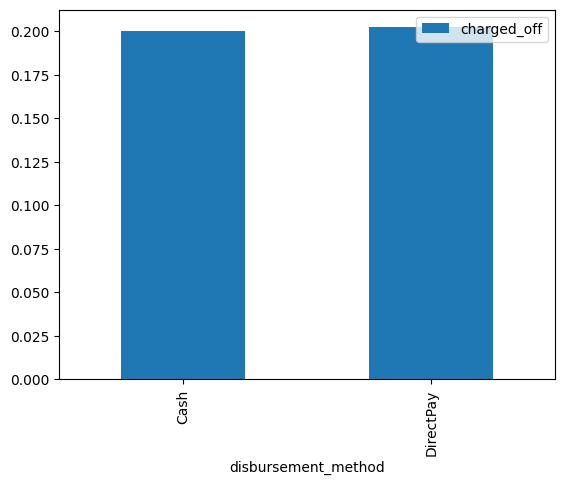

In [14]:
df_default.groupby(['disbursement_method'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

### `earliest_cr_line` - Convert to year and keep

There is a clear pattern of young and old borrowers tend to default.

In [15]:
df_default['earliest_cr_line'].value_counts()

earliest_cr_line
Aug-2001    4157
Oct-2001    3986
Sep-2004    3970
Aug-2002    3950
Sep-2003    3924
            ... 
Jul-1955       1
Apr-1958       1
May-1955       1
Sep-1959       1
May-1959       1
Name: count, Length: 718, dtype: int64

In [16]:
np.int64(df_default['earliest_cr_line'].str[-4:])

array([1987, 2000, 1996, ..., 2003, 2002, 2010])

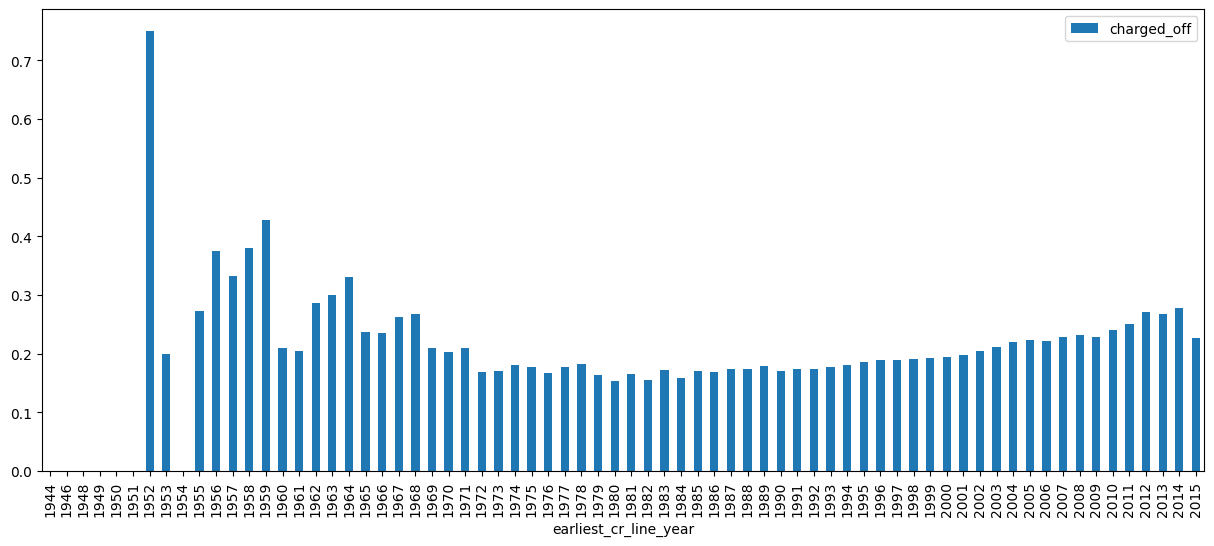

In [17]:
df_test = pd.DataFrame({'earliest_cr_line_year':np.int64(df_default['earliest_cr_line'].str[-4:]), 'charged_off':df_default['charged_off']})
df_test.groupby(['earliest_cr_line_year'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off', figsize=(15,6));

### `emp_length` (drop)

Doesn't seem to make a difference so let's drop.

In [18]:
df_default['emp_length'].value_counts()

emp_length
10+ years    195877
2 years       53780
< 1 year      47847
3 years       47392
1 year        39168
5 years       36954
4 years       35445
6 years       27800
8 years       26718
7 years       26333
9 years       22547
Name: count, dtype: int64

Let's map these values to integers so they are easier to graph.

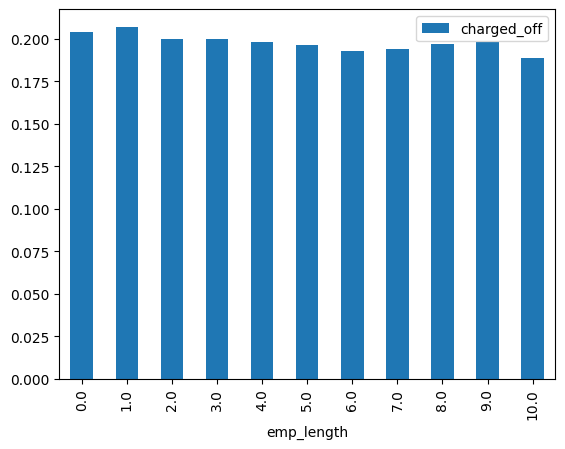

In [19]:
scale_mapper = \
{'< 1 year':0,
'1 year':1,
'2 years':2,
'3 years':3,
'4 years':4,
'5 years':5,
'6 years':6,
'7 years':7,
'8 years':8,
'9 years':9,
'10+ years':10}

df_test = pd.DataFrame({'emp_length':df_default['emp_length'].replace(scale_mapper), 'charged_off':df_default['charged_off']})
df_test.groupby(['emp_length'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `emp_title` (drop)

This looks like a free text and there are way too many values, so I am going to drop this.

In [20]:
df_default['emp_title'].value_counts()

emp_title
Teacher                              9357
Manager                              8482
Owner                                4565
Registered Nurse                     3869
RN                                   3727
                                     ... 
IT Mobile Workforce Analyst             1
Executive Secretary for Commander       1
UW Medicine                             1
Dog walker                              1
MEP PROGRAM MANAGER                     1
Name: count, Length: 195531, dtype: int64

### `grade` (keep)

Clearly the loan grade is related to chargeoff rate.

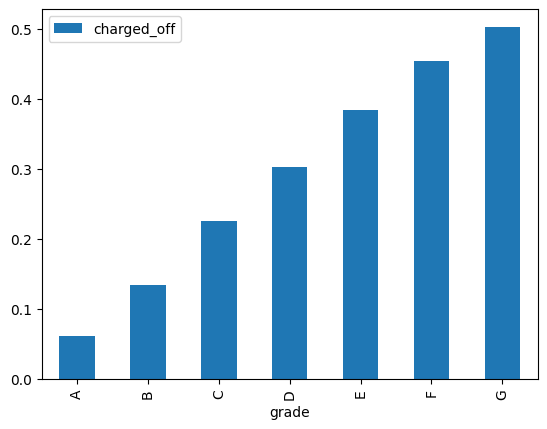

In [21]:
%matplotlib inline
df_default.groupby(['grade'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `hardship_flag` (drop)

All the same value

In [22]:
df_default['hardship_flag'].value_counts()

hardship_flag
N    594770
Name: count, dtype: int64

### `home_ownership` (keep)

As we can see, there are very few `ANY`, `OTHER`, `NONE`,  so let's just replace those with the most prevalent class which is `MORTGAGE`. **(Need to do this permanently to the data set.)**

In [23]:
df_default['home_ownership'].value_counts()

home_ownership
MORTGAGE    294144
RENT        236482
OWN          63933
ANY            132
OTHER           56
NONE            23
Name: count, dtype: int64

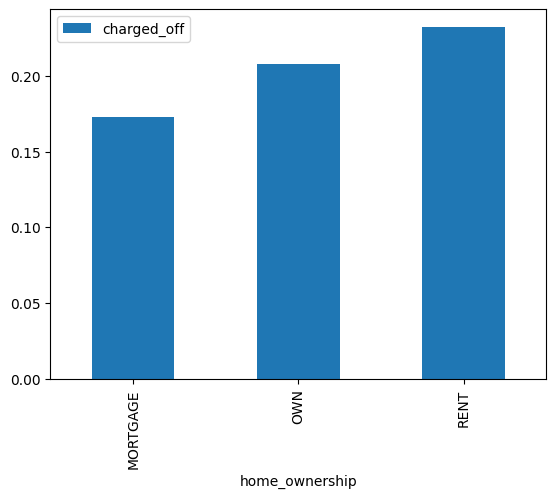

In [24]:
ownership_mapper = \
{'MORTGAGE':'MORTGAGE',
'RENT':'RENT',
'OWN':'OWN',
'ANY':'MORTGAGE',
'OTHER':'MORTGAGE',
'NONE':'MORTGAGE',}

df_test = pd.DataFrame({'home_ownership':df_default['home_ownership'].replace(ownership_mapper), 'charged_off':df_default['charged_off']})
df_test.groupby(['home_ownership'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

Renters tend to have higher default rates which makes sense.  It seems weird that `OWN` would have a higher charge-off rate that `MORTGAGE`.  Not sure how to interpret that.

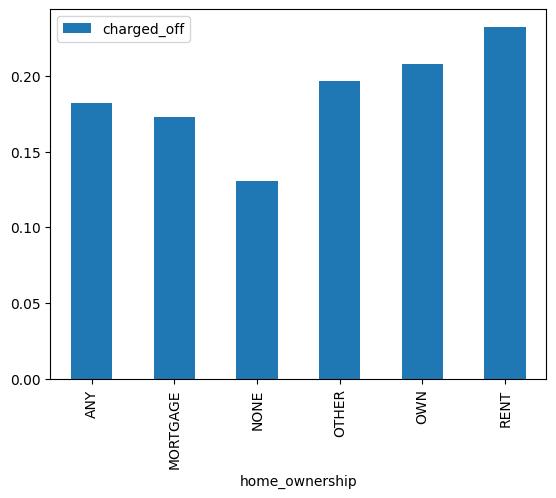

In [25]:
df_default.groupby(['home_ownership'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `initial_list_status` (drop)

No difference.

In [26]:
df_default['initial_list_status'].value_counts()

initial_list_status
w    346407
f    248363
Name: count, dtype: int64

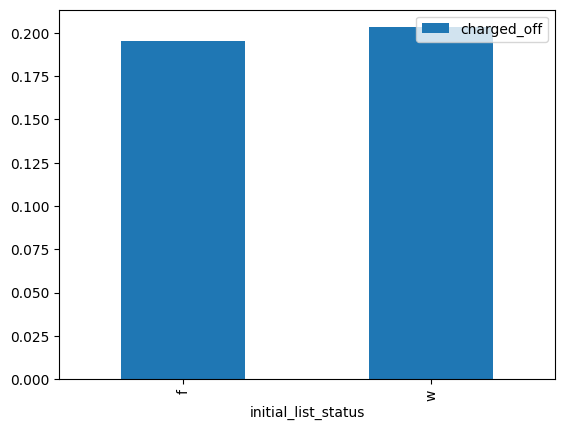

In [27]:
df_default.groupby(['initial_list_status'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

### `issue_d` (drop)

Month of origination doesn't seem to have an effect.

In [28]:
df_default['issue_d'].value_counts()

issue_d
Mar-2016    21664
Oct-2015    18903
Jul-2015    18095
Dec-2015    17339
Oct-2014    15775
            ...  
Aug-2007       17
Oct-2007       16
Sep-2008       14
Jul-2007       11
Sep-2007        5
Name: count, Length: 138, dtype: int64

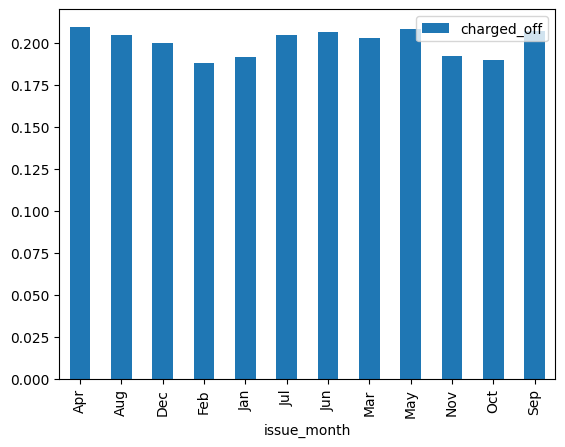

In [29]:
df_default['issue_d'].str[:3]
df_test = pd.DataFrame({'issue_month':df_default['issue_d'].str[:3], 'charged_off':df_default['charged_off']})
df_test.groupby(['issue_month'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `last_credit_pull_d` (drop)

baked into last FICO - if I wanted to go back I would add this back in.

### `last_pymnt_d` (drop)

baked into last FICO - if I wanted to go back I would add this back in.

### `purpose` (keep)

There seems to be a lot of variabilty in the default rate by purpose of the loan.  **Maybe get rid of the categories that only have a few entries, perhaps create an other category.**

In [30]:
df_default['purpose'].value_counts() 

purpose
debt_consolidation    345476
credit_card           130137
home_improvement       38570
other                  34501
major_purchase         12911
medical                 6974
small_business          6831
car                     6471
moving                  4179
vacation                3984
house                   3223
wedding                  970
renewable_energy         417
educational              126
Name: count, dtype: int64

In [31]:
df_default['purpose'].value_counts() / df_default['purpose'].shape[0]

purpose
debt_consolidation    0.580856
credit_card           0.218802
home_improvement      0.064849
other                 0.058007
major_purchase        0.021708
medical               0.011726
small_business        0.011485
car                   0.010880
moving                0.007026
vacation              0.006698
house                 0.005419
wedding               0.001631
renewable_energy      0.000701
educational           0.000212
Name: count, dtype: float64

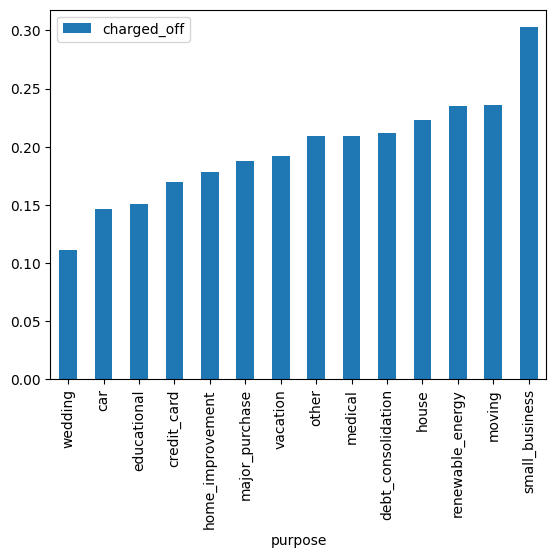

In [32]:
df_default.groupby(['purpose'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

### `pymnt_plan` (drop)

All the same value

In [33]:
df_default['pymnt_plan'].value_counts()

pymnt_plan
n    594770
Name: count, dtype: int64

### `sub_grade` (keep)

Clearly the `sub_grade` is related to `charged_off` rate.  Can probably drop `grade` in favor of `sub_grade`.

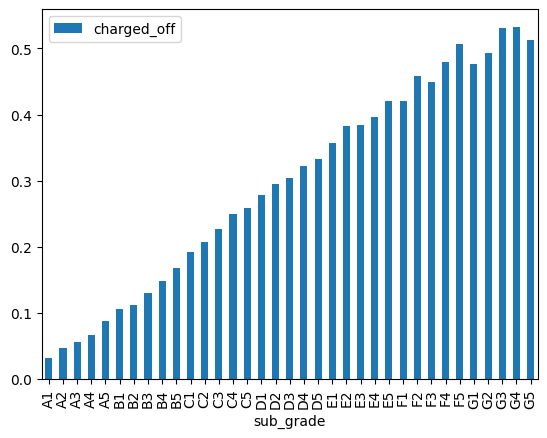

In [34]:
df_default.groupby(['sub_grade'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `term` (keep)

In [35]:
df_default['term'].value_counts()

term
 36 months    451510
 60 months    143260
Name: count, dtype: int64

The default rate for 60 month loans seems to be quite a bit higher, so let's keep this.

In [36]:
df_default.groupby(['term'])['charged_off'].agg(np.mean)

term
 36 months    0.160329
 60 months    0.325101
Name: charged_off, dtype: float64

### `title` (drop)

Seems like a more free-form version of purpose.  Lots of values so drop.

In [37]:
df_default['title'].value_counts()

title
Debt consolidation                         292576
Credit card refinancing                    110081
Home improvement                            33141
Other                                       29581
Major purchase                              10495
                                            ...  
I have a great job and I'm paying debt.         1
creditcard repay                                1
Lendng Club                                     1
Dental Business                                 1
Dan's Loan                                      1
Name: count, Length: 30758, dtype: int64

### `url` (drop)

All unique values

In [38]:
df_default['url'].value_counts()

url
https://lendingclub.com/browse/loanDetail.action?loan_id=39460023     1
https://lendingclub.com/browse/loanDetail.action?loan_id=1359747      1
https://lendingclub.com/browse/loanDetail.action?loan_id=11886440     1
https://lendingclub.com/browse/loanDetail.action?loan_id=38588593     1
https://lendingclub.com/browse/loanDetail.action?loan_id=3595154      1
                                                                     ..
https://lendingclub.com/browse/loanDetail.action?loan_id=107354128    1
https://lendingclub.com/browse/loanDetail.action?loan_id=90040773     1
https://lendingclub.com/browse/loanDetail.action?loan_id=60186700     1
https://lendingclub.com/browse/loanDetail.action?loan_id=77480901     1
https://lendingclub.com/browse/loanDetail.action?loan_id=76293448     1
Name: count, Length: 594770, dtype: int64

### `verification_status` (keep)

There seems to be differences in charged off rates, but it seems kind of weird to me that verified had a higher charge-off rate than not verified.  In any case we'll keep it.

In [39]:
df_default['verification_status'].value_counts()

verification_status
Source Verified    230747
Verified           184547
Not Verified       179476
Name: count, dtype: int64

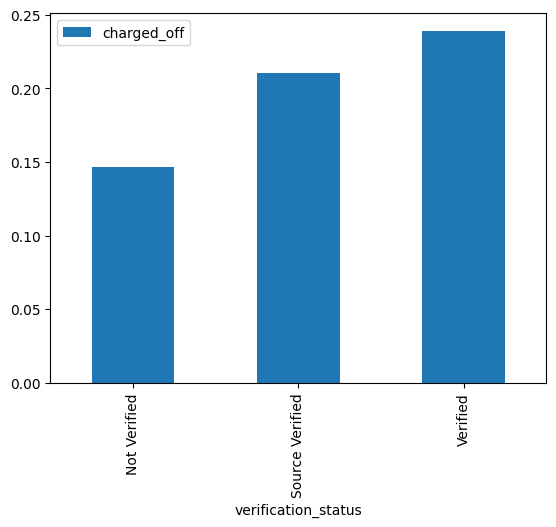

In [40]:
df_default.groupby(['verification_status'])['charged_off'].agg(np.mean).to_frame().plot(kind='bar', y='charged_off');

### `zip_code` (drop)

There seems to be quite a bit of variability, but the data is too granular to work with.  This is to some extent covered by `addr_state`.

In [41]:
df_default['zip_code'].value_counts()

zip_code
945xx    6679
750xx    6284
112xx    6110
606xx    5577
300xx    5398
         ... 
513xx       1
929xx       1
528xx       1
500xx       1
095xx       1
Name: count, Length: 920, dtype: int64

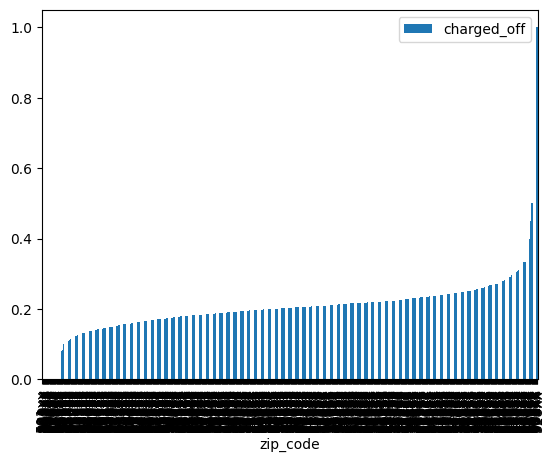

In [42]:
df_default.groupby(['zip_code'])['charged_off'].agg(np.mean).to_frame().sort_values('charged_off').plot(kind='bar', y='charged_off');

## Dropping Columns

In [43]:
to_drop = \
['emp_title',
 'emp_length',
 'issue_d',
 'pymnt_plan',
 'url',
 'title',
 'zip_code',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

In [44]:
df_default.drop(columns=to_drop, inplace=True)

Keeping just the year of `earliest_cr_line`.  This should be done in a `pipeline`

In [45]:
df_default['earliest_cr_line'] = np.int64(df_default['earliest_cr_line'].str[-4:])

In [46]:
df_default

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,charged_off
0,39460023,5625.0,5625.0,5625.0,36 months,12.39,187.89,C,C1,RENT,...,1.0,97.1,80.0,0.0,1.0,293006.0,48862.0,38400.0,20093.0,False
1,38202144,25000.0,25000.0,25000.0,36 months,6.49,766.12,A,A2,RENT,...,2.0,93.7,0.0,0.0,0.0,92905.0,38781.0,61400.0,27505.0,False
2,17343169,16000.0,16000.0,15950.0,60 months,19.52,419.65,E,E2,OWN,...,2.0,95.7,100.0,0.0,0.0,43167.0,35446.0,14500.0,19167.0,False
3,20682243,19100.0,19100.0,19100.0,36 months,18.24,692.82,D,D5,RENT,...,0.0,100.0,60.0,1.0,0.0,17900.0,9353.0,8000.0,0.0,False
4,10148376,20000.0,20000.0,20000.0,60 months,19.97,529.55,D,D5,RENT,...,2.0,95.7,80.0,0.0,0.0,61976.0,37767.0,21700.0,34976.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594765,144528743,10800.0,10800.0,10800.0,60 months,22.35,300.44,D,D5,RENT,...,4.0,100.0,18.2,0.0,0.0,183352.0,110799.0,66300.0,100752.0,False
594766,27150276,18000.0,18000.0,18000.0,36 months,10.99,589.22,B,B3,MORTGAGE,...,1.0,100.0,33.3,0.0,0.0,131100.0,46685.0,10500.0,0.0,False
594767,91428356,8000.0,8000.0,8000.0,36 months,7.49,248.82,A,A4,MORTGAGE,...,0.0,100.0,0.0,0.0,0.0,192040.0,48136.0,17100.0,40750.0,False
594768,23893875,24000.0,24000.0,24000.0,36 months,6.49,735.47,A,A2,RENT,...,1.0,100.0,0.0,0.0,0.0,368857.0,374166.0,27700.0,338957.0,False


In [47]:
pd.options.display.max_rows = 100

In [48]:
df_default.dtypes

id                              int64
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
home_ownership                 object
annual_inc                    float64
verification_status            object
purpose                        object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line                int64
fico_range_low                float64
fico_range_high               float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc                     float64
out_prncp                     float64
out_prncp_in

In [49]:
df_default.to_csv('data_processed/03_categorical_processed.csv', index=False)

In [50]:
lst_categorical = sorted(list(df_default.columns[df_default.dtypes=='object']))
lst_categorical

['addr_state',
 'grade',
 'home_ownership',
 'purpose',
 'sub_grade',
 'term',
 'verification_status']